In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, lower, body, upper, stop, holding):
    
    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['close'] = asset['Close']
    signals['open'] = asset['Open']
    signals['high'] = asset['High']
    signals['low'] = asset['Low']

    # In the red
    signals['condition1'] = np.where(signals['open'] >= signals['close'], 1, 0)

    # Small lower wick
    signals['condition2'] = np.where((signals['close']-signals['low']) < lower * abs(signals['close']-signals['open']), 1, 0)

    # Medium lower body
    signals['condition3'] = np.where(abs(signals['open']-signals['close']) < np.mean(abs(signals['open']-signals['close'])) * body, 1, 0)

    # Long upper wick
    signals['condition4'] = np.where((signals['high']-signals['open']) >= upper * (signals['open']-signals['close']), 1, 0)

    # Price uptrend
    signals['condition5'] = np.where(signals['close'] >= signals['close'].shift(1), 1, 0)
    signals['condition6'] = np.where(signals['close'].shift(1) >= signals['close'].shift(2), 1, 0)

    # Next high below high of shooting star 
    signals['condition7'] = np.where(signals['high'].shift(-1) <= signals['high'], 1, 0)

    # Next close below close of shooting star 
    signals['condition8'] = np.where(signals['close'].shift(-1) <= signals['close'], 1, 0)

    signals['signals'] = -signals['condition1']*signals['condition2']*signals['condition3']*signals['condition4']*signals['condition5']*signals['condition6']*signals['condition7']*signals['condition8']
        
    for i in range(len(signals)):
        if signals['signals'].iloc[i] == -1:
            for j in range(i, len(signals)):
                if abs(signals['close'].iloc[j]/signals['close'].iloc[i] - 1) > stop:
                    signals.at[signals.index[j], 'signals'] = 1
                    break
                if j - i >= holding:
                    signals.at[signals.index[j], 'signals'] = 1
                    break

    signals['positions'] = signals['signals'].cumsum()
    
    return signals


In [3]:
def plot(signals, ticker):

    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('Shooting Star', pad=15)
    plt.grid(True)
    plt.show()

    # Candlesticks
    plt.figure(figsize=(11,7))

    # Default bar size
    bar_size = 40
    bar = [-bar_size, 0, bar_size]
    
    for i in range(bar_size, len(signals) - bar_size, int(2.5 * bar_size)):
        x=[signals.index[i+j] for j in bar]
        y1=[min(signals['open'].iloc[i], signals['close'].iloc[i]) * 0.99] * 3
        y2=[max(signals['open'].iloc[i], signals['close'].iloc[i]) * 1.01] * 3

        # Check if open/close is high
        if signals['high'].iloc[i] != max(signals['open'].iloc[i], signals['close'].iloc[i]):
            plt.plot([signals.index[i], signals.index[i]], [y2[0], max(signals['open'].iloc[i], signals['close'].iloc[i]) * 1.1], c='black')
    
        # Check if open/close is low
        if signals['low'].iloc[i] != min(signals['open'].iloc[i],signals['close'].iloc[i]):
            plt.plot([signals.index[i], signals.index[i]], [y1[0], min(signals['open'].iloc[i], signals['close'].iloc[i]) * 0.9], c='black')
        
        plt.fill_between(x,y1,y2, edgecolor='black', facecolor=('r' if signals['open'].iloc[i] > signals['close'].iloc[i] else 'g'))

    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Price', labelpad=15)
    plt.title('Shooting Star', pad=15)
    plt.grid(True)
    plt.show()

In [4]:
def ShootingStar(ticker, start_date, end_date, capital):
    
    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Default lower/upper wick and body sizes, stop loss/profit threshold, and holding period
    signals = signal_generation(asset, 0.5, 0.8, 1.3, 0.1, 7)

    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'Shooting Star'), signals, start_date, end_date, capital)

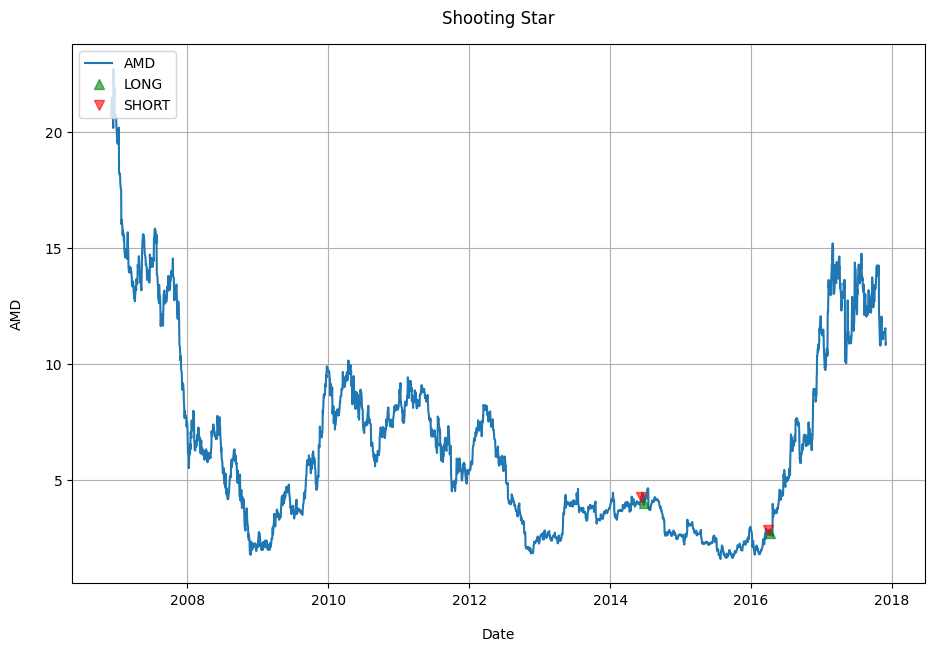

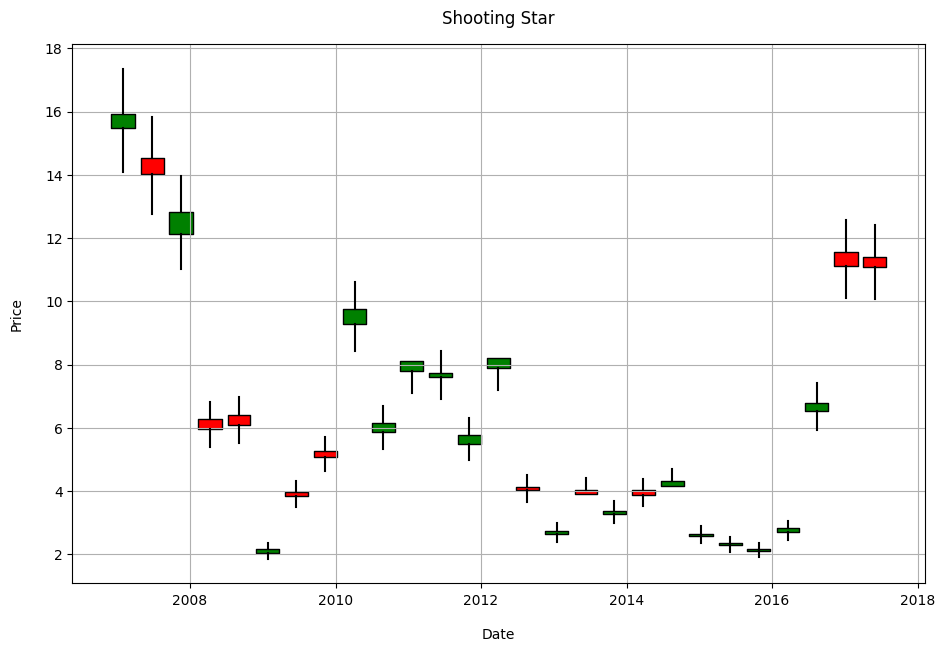

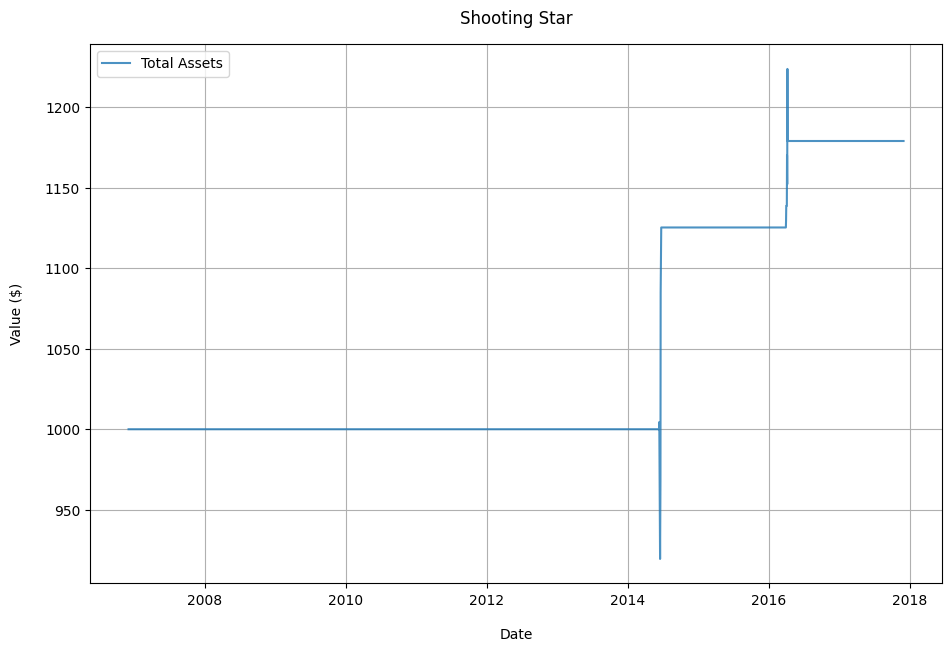

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.178971,0.890278,0.000059,-0.052802,-0.084632,-0.000703,3.5,44.742689


In [5]:
ShootingStar('AMD', '2006-12-01', '2017-12-01', 1000)